## 1D Reaction Diffusion Modeling ##

This notebook is a numerical solver for a 1D reaction-diffusion system where a concentrated feedstock is added to a gel prepared with a concentration of a flocculant, or counterion.
The system of partial differential equations comes from Fick's law of diffusion with a reaction term where $c_i$ is a concentration of some reagent $i$, $D_i$ is its diffusion coefficient,
and $x$ is distance in 1 dimension. Finally the reaction term $r_i$ is the rate of formation based off of the reaction kinetics.

$\frac{\partial C_i}{\partial t} = D_i \frac{\partial C_i}{\partial x} + r_i$

Making the final system of equations the following for a feedstock of $Co^{-2}$, and where the flocculant is $PO_4^{-3}$, and where the reaction product is $Co_3(PO_4)_2$

$\frac{\partial C_{Co}}{\partial t} = D_{Co} \frac{\partial C_{Co}}{\partial x} - 3r$

$\frac{\partial C_{PO_4}}{\partial t} = D_{PO_4} \frac{\partial C_{PO_4}}{\partial x} - 2r$

$\frac{\partial C_{Co_3(PO_4)_2}}{\partial t} = D_{Co_3(PO_4)_2} \frac{\partial C_{Co_3(PO_4)_2}}{\partial x} + r$

where
 $r = kC_1^3C_2^2$


In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- spatial grid ---
L = 10
N = 500
x = np.linspace(0, L, N)
dx = x[1] - x[0]

# --- parameters ---
D_Co = 1e-5         #Diffusion coefficient for Co
D_PO4 = 1e-5        #Diffusion coefficient for PO4
D_solid = 0.0       # solid doesn't diffuse
k = 1e2             # reaction rate constant
t_span = (0, 500000)
t_eval = np.linspace(*t_span, 1000)

# --- initial conditions ---
Co0 = np.zeros(N)
PO40 = np.zeros(N)
Solid0 = np.zeros(N)

# Co in left tenth
Co0[: N // 20] = 0.5
# PO4 fills the rest of the space
PO40[N // 20 :] = 0.1

# concatenate into single vector
C0 = np.concatenate([Co0, PO40, Solid0])

# --- helper: 1D Laplacian with zero-flux BCs ---
def laplacian(u):
    dudx2 = np.zeros_like(u)
    dudx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    return dudx2

# --- PDE system ---
def rhs(t, C):
    Co = C[0:N]
    PO4 = C[N:2*N]
    Solid = C[2*N:3*N]

    # Reaction rate (irreversible)
    r = k * (np.maximum(Co, 0)**3) * (np.maximum(PO4, 0)**2)

    d2Co = laplacian(Co)
    d2PO4 = laplacian(PO4)
    d2Solid = laplacian(Solid)

    dCo_dt = D_Co * d2Co - 3 * r
    dPO4_dt = D_PO4 * d2PO4 - 2 * r
    dSolid_dt = D_solid * d2Solid + r

    return np.concatenate([dCo_dt, dPO4_dt, dSolid_dt])

# --- solve the system ---
sol = solve_ivp(rhs, t_span, C0, t_eval=t_eval, method="BDF")

# --- extract concentrations ---
Co_sol = sol.y[0:N, :]
PO4_sol = sol.y[N:2*N, :]
Solid_sol = sol.y[2*N:3*N, :]

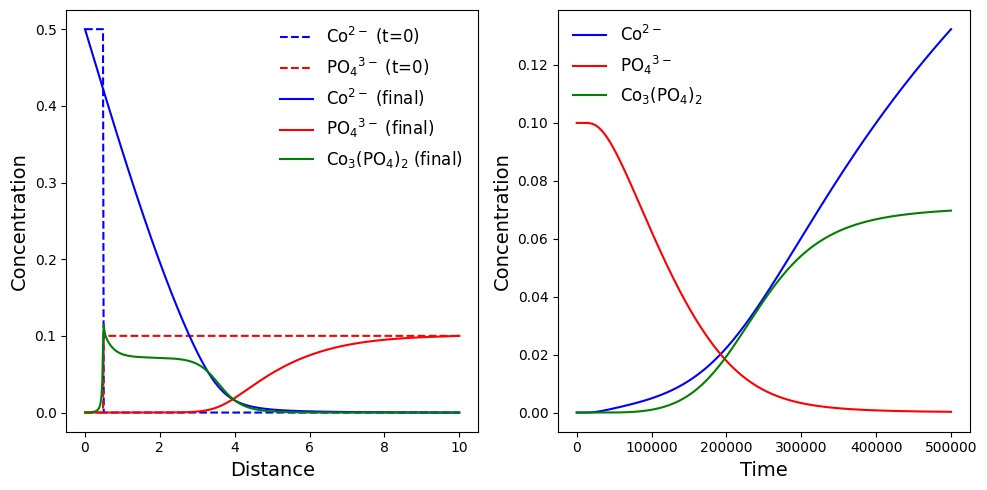

In [7]:
# --- plotting ---
Co_color = 'blue'
PO4_color = 'red'
solid_color = 'green'

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, Co_sol[:, 0], '--', label='Co$^{2-}$ (t=0)', color=Co_color)
plt.plot(x, PO4_sol[:, 0], '--', label='PO$_4$$^{3-}$ (t=0)', color=PO4_color)
plt.plot(x, Co_sol[:, -1], label='Co$^{2-}$ (final)', color=Co_color)
plt.plot(x, PO4_sol[:, -1], label='PO$_4$$^{3-}$ (final)', color=PO4_color)
plt.plot(x, Solid_sol[:, -1], label='Co$_3$(PO$_4$)$_2$ (final)', color=solid_color)
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Concentration', fontsize=14)
plt.legend(fontsize=12, loc='upper right',frameon=False)
#plt.title('Profiles: initial (dashed) vs final (solid)')

# time evolution at midpoint near reaction zone
front_idx = N // 4
plt.subplot(1, 2, 2)
plt.plot(sol.t, Co_sol[front_idx, :], label='Co$^{2-}$', color=Co_color)
plt.plot(sol.t, PO4_sol[front_idx, :], label='PO$_4$$^{3-}$', color=PO4_color)
plt.plot(sol.t, Solid_sol[front_idx, :], label='Co$_3$(PO$_4$)$_2$', color=solid_color)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Concentration', fontsize=14)
plt.legend(fontsize=12, loc='upper left',frameon=False)
#plt.title(f'Time series at x = {x[front_idx]:.2f}')

plt.tight_layout()
plt.show()

## Animation ##
The following cells animate the reaction-diffusion curve that was plotted previously
This next cell animates the reaction-diffusion concentration for the entire volume of gel for all positions, x, over time.

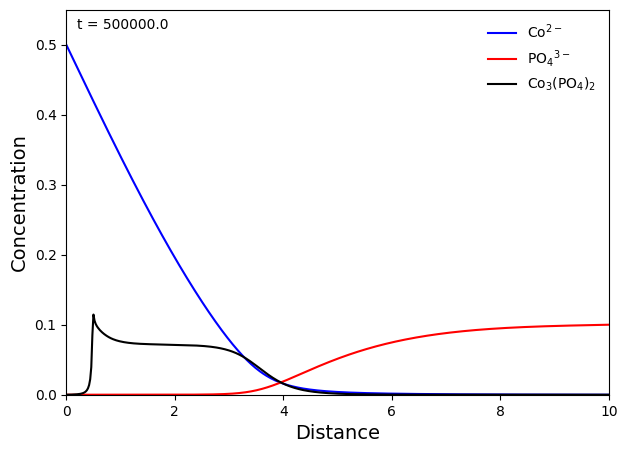

In [8]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(0, L)
ax.set_ylim(0, max(Co_sol.max(), PO4_sol.max(), Solid_sol.max())*1.1)
ax.set_xlabel('Distance', fontsize=14)
ax.set_ylabel('Concentration', fontsize=14)

line_co, = ax.plot([], [], 'b-', label='Co$^{2-}$')
line_po4, = ax.plot([], [], 'r-', label='PO$_4$$^{3-}$')
line_solid, = ax.plot([], [], 'k-', label='Co$_3$(PO$_4$)$_2$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.legend(frameon=False)

def init():
    line_co.set_data([], [])
    line_po4.set_data([], [])
    line_solid.set_data([], [])
    time_text.set_text('')
    return line_co, line_po4, line_solid, time_text

def update(frame):
    line_co.set_data(x, Co_sol[:, frame])
    line_po4.set_data(x, PO4_sol[:, frame])
    line_solid.set_data(x, Solid_sol[:, frame])
    time_text.set_text(f't = {t_eval[frame]:.1f}')
    return line_co, line_po4, line_solid, time_text

anim = FuncAnimation(fig, update, frames=len(t_eval),
                     init_func=init, blit=True, interval=80)

# --- save as MP4 ---
writer = FFMpegWriter(fps=120, metadata=dict(artist='Me'), bitrate=32000)
anim.save('reaction_diffusion.mp4', writer=writer)

This cell animates the reaction diffusion process at a single position, x, over time.

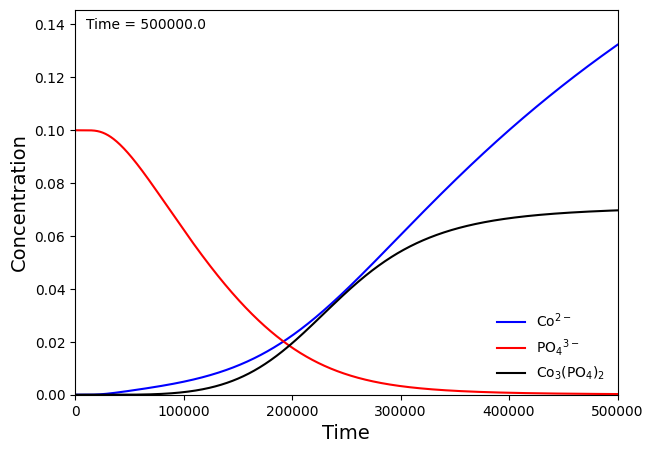

In [9]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt

# Choose the spatial position you want to track
front_idx = N // 4  # for example

fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(t_eval[0], t_eval[-1])
ax.set_ylim(0, max(Co_sol[front_idx,:].max(),
                   PO4_sol[front_idx,:].max(),
                   Solid_sol[front_idx,:].max())*1.1)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Concentration', fontsize=14)

line_co, = ax.plot([], [], 'b-', label='Co$^{2-}$')
line_po4, = ax.plot([], [], 'r-', label='PO$_4$$^{3-}$')
line_solid, = ax.plot([], [], 'k-', label='Co$_3$(PO$_4$)$_2$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.legend(frameon=False)

def init():
    line_co.set_data([], [])
    line_po4.set_data([], [])
    line_solid.set_data([], [])
    time_text.set_text('')
    return line_co, line_po4, line_solid, time_text

def update(frame):
    # Slice up to current frame for a “growing” curve
    t_slice = t_eval[:frame+1]
    line_co.set_data(t_slice, Co_sol[front_idx, :frame+1])
    line_po4.set_data(t_slice, PO4_sol[front_idx, :frame+1])
    line_solid.set_data(t_slice, Solid_sol[front_idx, :frame+1])
    time_text.set_text(f'Time = {t_eval[frame]:.1f}')
    return line_co, line_po4, line_solid, time_text

anim = FuncAnimation(fig, update, frames=len(t_eval),
                     init_func=init, blit=True, interval=80)

# --- save as MP4 ---
writer = FFMpegWriter(fps=120, metadata=dict(artist='Me'), bitrate=32000)
anim.save('reaction_at_position.mp4', writer=writer)
